# Winning Jeopardy: Searching for Successful Strategies

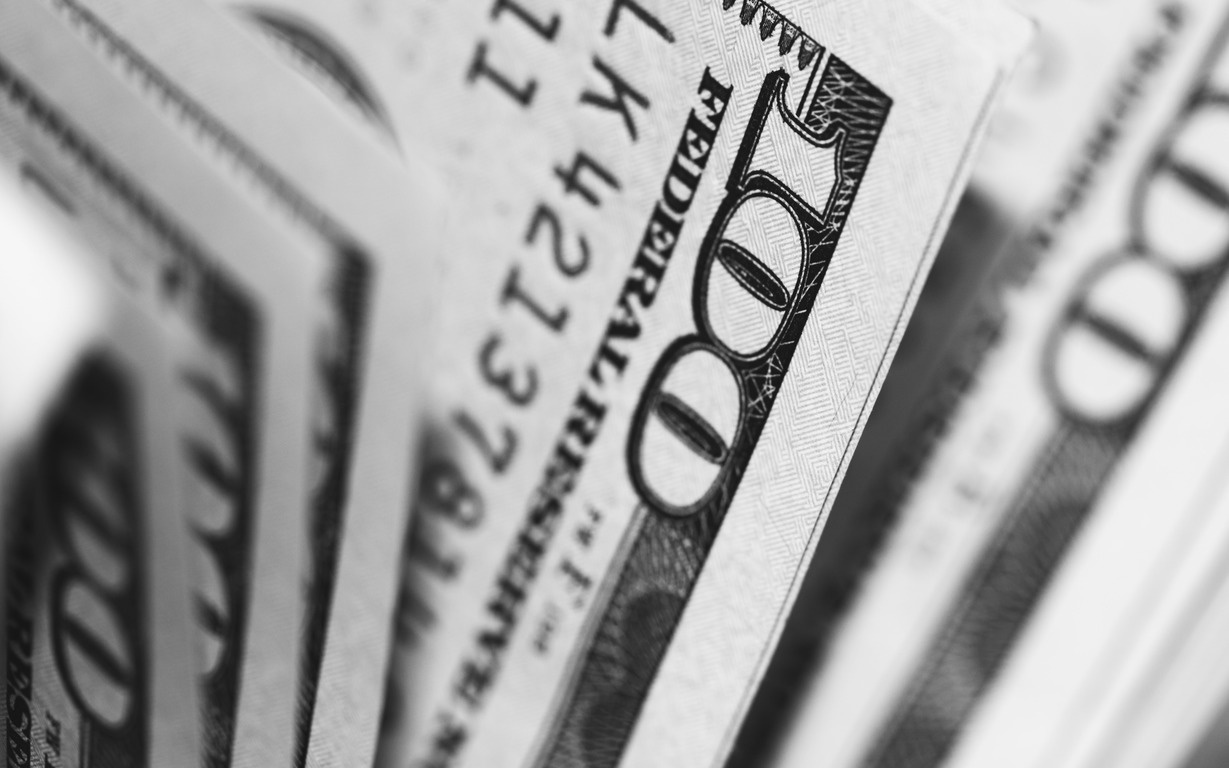

## Introduction
[Jeopardy](https://en.wikipedia.org/wiki/Jeopardy!) is a popular TV quiz running for many years in the U.S. where participants are presented with general knowledge clues in the form of answers and must phrase their responses in the form of questions to have a chance to win money. You can find its official website [here](https://www.jeopardy.com).

The aim of this project is to figure out some patterns in the questions that could help us win. We'll work with a dataset containing about 20,000 rows from the beginning of a full dataset of Jeopardy questions, available for downloading [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file). Each row represents a single question on a single episode of Jeopardy.
### Summary of Results
After trying different approaches (checking if the answer tends to be hinted in a question, investigating the possibility of question recycling, searching for the words related to high value questions, exploring the most frequent categories) we concluded that the only realistic and potentially prospective way forward can be investigating question recycling in more detail.

## Data Downloading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # to suppress gensim-levenshtein version conflict
import gensim

jeopardy = pd.read_csv('jeopardy.csv')
print(f'Number of rows: {jeopardy.shape[0]} \n'
      f'Number of columns: {jeopardy.shape[1]} \n'
      f'Number of missing values: {jeopardy.isnull().sum().sum()}\n')
jeopardy.head()

Number of rows: 19999 
Number of columns: 7 
Number of missing values: 0



,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


The column names are self-explanatory. The `Value` column shows the number of dollars the correct answer is worth. There are no missing values in the dataframe.

In [2]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

Some of the column names have spaces in front, which should be fixed:

In [3]:
# Removing leading spaces from column names
cleaned_column_names = []
for column in jeopardy.columns:
    cleaned_column_names.append(column.lstrip())

jeopardy.columns = cleaned_column_names
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

## Normalizing Columns
Now, let's normalize some columns to make it easier to conduct data analysis:
- `Question` and `Answer` – putting words in lowercase and removing punctuation,
- `Value` – removing the dollar sign and converting each value to numeric,
- `Air Date` – making it  datetime.

In [4]:
def normalize_text(text):
    '''Converts a string to lowercase and removes all punctuation'''
    text=text.lower()
    text=re.sub('[^A-Za-z0-9\s]', '', text)
    text=re.sub('\s+', ' ', text)
    return text

def normalize_value(string):
    '''Takes in a string, removes any punctuation, converts to an integer, 
    otherwise assigns 0. Returns the integer.
    '''
    value=re.sub('[^\w\s]','',string)
    try:
        value=int(value)
    except Exception:
        value=0
    return value

jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_value)
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])
jeopardy.head(2)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200


## Answers in Questions
In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:
- How often the answer can be used for a question.
- How often questions are repeated.

To answer the first question, we can check how many times words in the answer also occur in the question.

In [5]:
def count_matches(row):
    '''Takes in a row in Jeopardy as a Series and returns how many times
    words in the answer occur in the question.
    '''
    split_answer=row['clean_answer'].split()
    split_question=row['clean_question'].split()
    match_count=0
    if 'the' in split_answer:
        split_answer.remove('the')
    if len(split_answer)==0:
        return 0
    for item in split_answer:
        if item in split_question:
            match_count+=1
    return match_count/len(split_answer)

jeopardy['answer_in_question'] = jeopardy.apply(count_matches, axis=1)
answer_in_question_pct = round(jeopardy['answer_in_question'].mean()*100)
print(f'In {answer_in_question_pct}% of cases, the answer appears in the question.')

In 6% of cases, the answer appears in the question.


Only in 6% of cases, the answer is mentioned in the question. Hence, we cannot rely on this approach, so let's reject it and proceed with the second one.
## Recycled Questions
We're going to find out how often new questions are repeats of older ones. This approach also has an issue from the very beginning: we only have about 10% of the full Jeopardy question dataset. However, let's investigate it anyway.

The idea is to check if the words in the questions have been used previously or not. We need to consider only meaningful words, excluding auxiliary or commonly used ones such as *and* or *did*. To filter out low-informative words, we'll use a stop word list. Since there is no universal or full stop word list, let's combine ours from the stop word lists of 3 different libraries: `stop_words`, `gensim`, and `sklearn`. It won't be perfect or full anyway, and there are some other libraries providing their lists. However, it's a more reliable approach than using only one stop word list.

In [6]:
from stop_words import get_stop_words
stop_words = get_stop_words('en')

from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Combining stop word lists from different libraries 
stopword_list = list(set(stop_words+list(STOPWORDS)+list(ENGLISH_STOP_WORDS)+['1','2','3','4','5','6','7','8','9','0']))
print(f'STOP WORDS:\n'
      f'\n{stopword_list}')

STOP WORDS:

['now', 'bottom', 'behind', 'always', 'these', 'after', 'then', 'hers', 'by', 'empty', 'such', 'toward', 'noone', '9', "we'd", '4', 'too', 'twelve', 'it', 'so', 'nobody', "here's", 'we', 'what', 'ought', 'few', 'why', 'eleven', 'a', 'became', 'somewhere', 'call', 'neither', "we're", 'you', 'my', 'without', 'or', 'six', 'computer', 'is', 'perhaps', 'throughout', 'above', 'name', 'eg', 'two', 'were', "mustn't", 'whoever', 'ours', 'three', "they've", 'hence', 'more', 'something', 'thereby', 'other', "shouldn't", 'often', 'none', "we've", 'until', 'couldnt', 'if', 'us', 'five', 'co', 'though', 'be', 'either', "wouldn't", 'eight', '7', 'are', 'enough', 'inc', 'from', 'meanwhile', 'yourself', 'bill', 'the', 'ten', "it's", "where's", 'twenty', 'had', 'cry', 'only', "what's", 'namely', 'quite', 'wherein', 'done', 'four', 'on', 'and', 'might', 'whenever', 'again', 'out', 'forty', 'should', 'even', 'hereafter', 'thereupon', "you'll", 'don', 'alone', "hasn't", 'whereupon', 'during', 

Let's calculate the percentage of meaningful word overlap in all the questions of our dataset:

In [7]:
question_overlap = []
terms_used = set()
terms_used_list = []

jeopardy.sort_values(by=['Air Date'])

for i, row in jeopardy.iterrows():
    split_question=row['clean_question'].split(' ')
    match_count=0
    
    # Removing stop words
    split_question=[x for x in split_question if x not in stopword_list]
    
    for word in split_question:
        if word in terms_used:
            match_count+=1     # the number of repeated words
    for word in split_question:
        terms_used.add(word)   # a set of unique words in all the questions
        terms_used_list.append(word)
    if len(split_question)>0:
        match_count/=len(split_question)
    question_overlap.append(match_count)
    
jeopardy['question_overlap'] = question_overlap
question_overlap_pct = round(jeopardy['question_overlap'].mean()*100)
print(f'{question_overlap_pct}% of meaningful word overlap in questions.')

78% of meaningful word overlap in questions.


We observe a significant overlap between meaningful words of all the questions of our dataset. Even though we're looking only at 10% of questions of the full Jeopardy dataset and ignore collocations between words (and, hence, lose context), we can assume that some question recycling is quite possible and should be investigated in more detail.
## Low Value vs High Value Questions
Since our major goal is to earn more money on Jeopardy, let's focus on high value questions instead of low value ones. For this purpose, we should figure out which words correspond to high-value questions using a chi-squared test, but first, we need to split the questions into two categories:
- low value – with the value <= 800,
- high value – with the value > 800.

We're going to perform the chi-squared test across the 50 most frequent words in the whole dataset to see which ones have larger differences between the number of high and low value questions where they occurred (doing this for all of the words would take a very long time).

In [8]:
def sort_values(row):
    '''Takes in a row in Jeopardy as a Series and categorizes questions as
    high or low value ones.
    '''
    if row['clean_value']>800:
        value=1
    else:
        value=0
    return value

def count_values(word):
    '''Takes in a word and separately returns the numbers of high and low value
    questions the word occurs in.
    '''
    low_count=0
    high_count=0
    for i, row in jeopardy.iterrows():
        split_question=row['clean_question'].split(' ')
        if word in split_question:
            if row['high_value']==1:
                high_count+=1
            else:
                low_count+=1
    return high_count, low_count

jeopardy['high_value'] = jeopardy.apply(sort_values, axis=1)

# Creating a list of the 50 most frequent words in all the questions
comparison_terms = list(pd.Series(terms_used_list).value_counts()[:50].index)

# Extracting high and low values for each of the TOP50 words
observed_high_low = []
for word in comparison_terms:
    observed_high_low.append(count_values(word))
    
print(f'The 50 most frequent words in the whole dataset:'
      f'\n{comparison_terms}')
print(f'\nNumber of times each word occurred in high and low value questions:'
      f'\n{observed_high_low}')

The 50 most frequent words in the whole dataset:
['city', 'called', 'named', 'like', 'country', 'man', 'new', 'seen', 'state', 'type', 'clue', 'film', 'title', 'crew', 'known', 'word', 'years', 'said', 'played', 'wrote', 'term', 'novel', 'world', 'president', 'capital', 'american', 'famous', 'targetblankherea', 'french', 'book', 'king', 'won', 'home', 'time', 'island', 'war', 'john', 'song', 'means', 'great', 'hit', 'born', 'play', 'river', 'people', 'national', 'im', 'work', 'day', 'largest']

Number of times each word occurred in high and low value questions:
[(151, 407), (168, 346), (177, 325), (136, 343), (141, 332), (136, 320), (130, 305), (125, 321), (122, 300), (143, 290), (185, 200), (114, 294), (121, 248), (177, 187), (125, 223), (113, 199), (85, 225), (70, 223), (77, 212), (88, 195), (88, 186), (90, 174), (72, 184), (68, 181), (61, 186), (77, 174), (78, 168), (97, 146), (108, 133), (64, 168), (86, 141), (67, 154), (69, 145), (45, 163), (73, 134), (57, 148), (72, 134), (52, 15

## Applying the Chi-Squared Test
Now that we've found the observed counts for the 50 most frequent words, we can compute the expected counts, chi-squared values, and p-values:

In [9]:
# Counting high and low value questions
high_value_count = len(jeopardy[jeopardy['high_value']==1])
low_value_count = len(jeopardy[jeopardy['high_value']==0])

# Counting chi-squared and p-values for each word
chi_squared = []
for item in observed_high_low:
    total=item[0]+item[1]    # the number of questions a word occurs in
    total_prop=total/len(jeopardy)
    expected_high=total_prop*high_value_count
    expected_low=total_prop*low_value_count
    observed=np.array([item[0], item[1]])
    expected=np.array([expected_high, expected_low])
    chi_squared.append(chisquare(observed, expected))

chi_squared[:5]

[Power_divergenceResult(statistic=0.7076909717756055, pvalue=0.40021142063886284),
 Power_divergenceResult(statistic=4.048305063534577, pvalue=0.044215717944225866),
 Power_divergenceResult(statistic=10.652121238596461, pvalue=0.0010994473639157583),
 Power_divergenceResult(statistic=0.018225226791183866, pvalue=0.8926112102157906),
 Power_divergenceResult(statistic=0.29967829483482744, pvalue=0.5840841713114313)]

To display the results in a more readable form, let's create a dataframe where we'll include only the words with a big difference between the number of high and low value questions where these words occurred, and, at the same time, with p-value lower than 0.05, meaning that the results are significant and cannot be explained just by a random chance. 

In [10]:
list_of_lists = []
for i in range(50):
    lst=[]
    
    # Adding the word associated with each pair of chi-squared and p-value 
    lst.append(comparison_terms[i])  
    
    lst.append(list(chi_squared[i])[0])   # high value question number
    lst.append(list(chi_squared[i])[1])   # low value question number
    list_of_lists.append(lst)
    
words = pd.DataFrame(list_of_lists, columns=['Word', 'Chi_squared', 'p_val'])
words = words.sort_values(by=['Chi_squared'], ascending=False).reset_index(drop=True)
words = words[words['p_val']<0.05]
words

,Word,Chi_squared,p_val
0,crew,70.874390,3.807079e-17
1,clue,70.709608,4.138719e-17
2,french,30.705096,3.003752e-08
3,targetblankherea,15.028297,1.059112e-04
4,named,10.652121,1.099447e-03
5,king,9.423497,2.142226e-03
6,known,8.939547,2.790620e-03
7,word,8.688296,3.202600e-03
8,time,5.036201,2.482286e-02
9,island,4.401396,3.590952e-02


The 16 words in the dataframe demonstrate a big difference between the number of high and low value questions, and the results are statistically significant. However, what is the direction of their differences? Does it mean that they occur mostly in high value questions or, just the opposite, in low value ones? Logically, at this point, we can expect that some of these words occurred mostly in high value questions (our target here), others – in low value questions. To check it and to find the words mostly occurring in high value questions, let's create another dataframe containing all the 16 words and their corresponding high and low value question counts:

In [11]:
comparison_terms_updated = list(words['Word'])

observed_high_low_updated = []
for word in comparison_terms_updated:
    observed_high_low_updated.append(count_values(word))
    
print(f'The words with a big difference between the number of high and low value questions:'
      f'\n{comparison_terms_updated}')
print(f'\nNumber of times each word occurred in high and low value questions:'
      f'\n{observed_high_low_updated}')

list_of_lists_new = []
for i in range(16):
    lst=[]
    lst.append(comparison_terms_updated[i])
    lst.append(list(observed_high_low_updated[i])[0])
    lst.append(list(observed_high_low_updated[i])[1])
    list_of_lists_new.append(lst)
    
significant_words = pd.DataFrame(list_of_lists_new, columns=['Word', 'High', 'Low'])
significant_words

The words with a big difference between the number of high and low value questions:
['crew', 'clue', 'french', 'targetblankherea', 'named', 'king', 'known', 'word', 'time', 'island', 'play', 'river', 'means', 'called', 'type', 'john']

Number of times each word occurred in high and low value questions:
[(177, 187), (185, 200), (108, 133), (97, 146), (177, 325), (86, 141), (125, 223), (113, 199), (45, 163), (73, 134), (67, 122), (65, 118), (72, 133), (168, 346), (143, 290), (72, 134)]


,Word,High,Low
0,crew,177,187
1,clue,185,200
2,french,108,133
3,targetblankherea,97,146
4,named,177,325
5,king,86,141
6,known,125,223
7,word,113,199
8,time,45,163
9,island,73,134


For the words that mostly occurred in high value questions and demonstrate statistical significance, we expect to have the high value question count greater than the low value question count. Let's find these words:

In [12]:
significant_words[(significant_words['High']-significant_words['Low'])>0]

,Word,High,Low


We see that there are no such words among our selection of 16 words! It means that all of them tend to occur in low value questions, and it's not due to a random chance.

This outcome is probably not so surprising. Indeed, we have much more low value questions than high value ones:

In [13]:
print(f'Number of high value questions: {high_value_count:,}'
      f'\nNumber of low value questions:  {low_value_count:,}')

Number of high value questions: 5,734
Number of low value questions:  14,265


Given this fact, and also that from the beginning we focused on the 50 most frequent words from our dataset, it looks rather probable that all the 50 words mostly occurred in low value questions. As a possible solution, we could continue digging deeper into our set of words, extracting and analyzing the next 50 most frequent words, then, if we're still not satisfied, the next ones, and so on. However, it doesn't seem very feasible, since we have a huge number of unique words in all the questions available:

In [14]:
print(f'Number of unique words (ignoring the stopwords): {len(terms_used):,}')

Number of unique words (ignoring the stopwords): 33,156


Even if at a certain point we'll find some words mostly occurring in high value questions, showing statistically significant results, and being still rather frequent (since we're definitely not interested in words that occurred, say, 10 times in all the questions), these findings would be of low practical use for us, because of several reasons:
- The process of digging deeper will take very much time.
- Knowing the ideal "high value" words, there is still a very low probability to encounter exactly them in the next round.
- The fact of knowing and even encountering them in the next questions doesn't yet suggest us any correct answer. 

Because of the same reasons, we have to reject alternative approaches:
- Using the whole Jeopardy set (now we're using only 10% of all the questions from it). Besides, it's not available anymore on its [link](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file).
- Randomly extracting 10, 50, 100, etc. words and conducting chi-squared test on this subset. Here we also should keep in mind that the great majority of unique words have very low frequencies.

## Finding the Most Frequent Categories
Till now, the only realistic and potentially prospective approach we found is the one of further investigating question recycling. Let's now explore another possible way of increasing our chances to win Jeopardy: analyzing the most frequent categories of questions and, probably, preparing in advance for exactly those topics. 

In [15]:
unique_categories = jeopardy['Category'].nunique()
print(f'Number of unique categories: {unique_categories:,}')

Number of unique categories: 3,581


There are a lot of unique categories, so let's narrow our focus to the TOP20 ones. We're going to find these the TOP20 categories both for all the questions altogether and separately by round. The Jeopardy quiz consists of three rounds: *Jeopardy!*, *Double Jeopardy!*, and *Final Jeopardy!*

In [16]:
list(jeopardy['Round'].unique())

['Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!', 'Tiebreaker']

Here *Tiebreaker* is a situation when two or more participants tie for the highest score at the end of the match. Since it isn't a round name, we'll exclude it and visualize the number of questions by round:

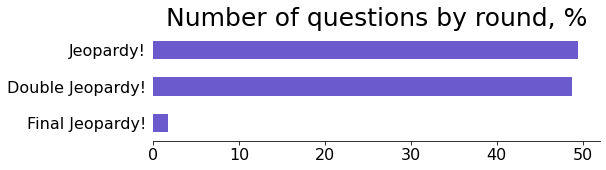

In [17]:
rounds = jeopardy[jeopardy['Round']!='Tiebreaker']
rounds = rounds['Round'].value_counts(ascending=True)*100/len(rounds)

fig, ax = plt.subplots(figsize=(8,2))
rounds.plot.barh(color='slateblue')
ax.set_title('Number of questions by round, %', fontsize=25)
ax.set_xlabel(None)
ax.tick_params(axis='both', labelsize=16, left=False)
sns.despine(left=True)
plt.show()

Only about 2% of all the questions are related to the 3rd round (*Final Jeopardy!*) and relatively comparable numbers of questions – to the first two rounds.

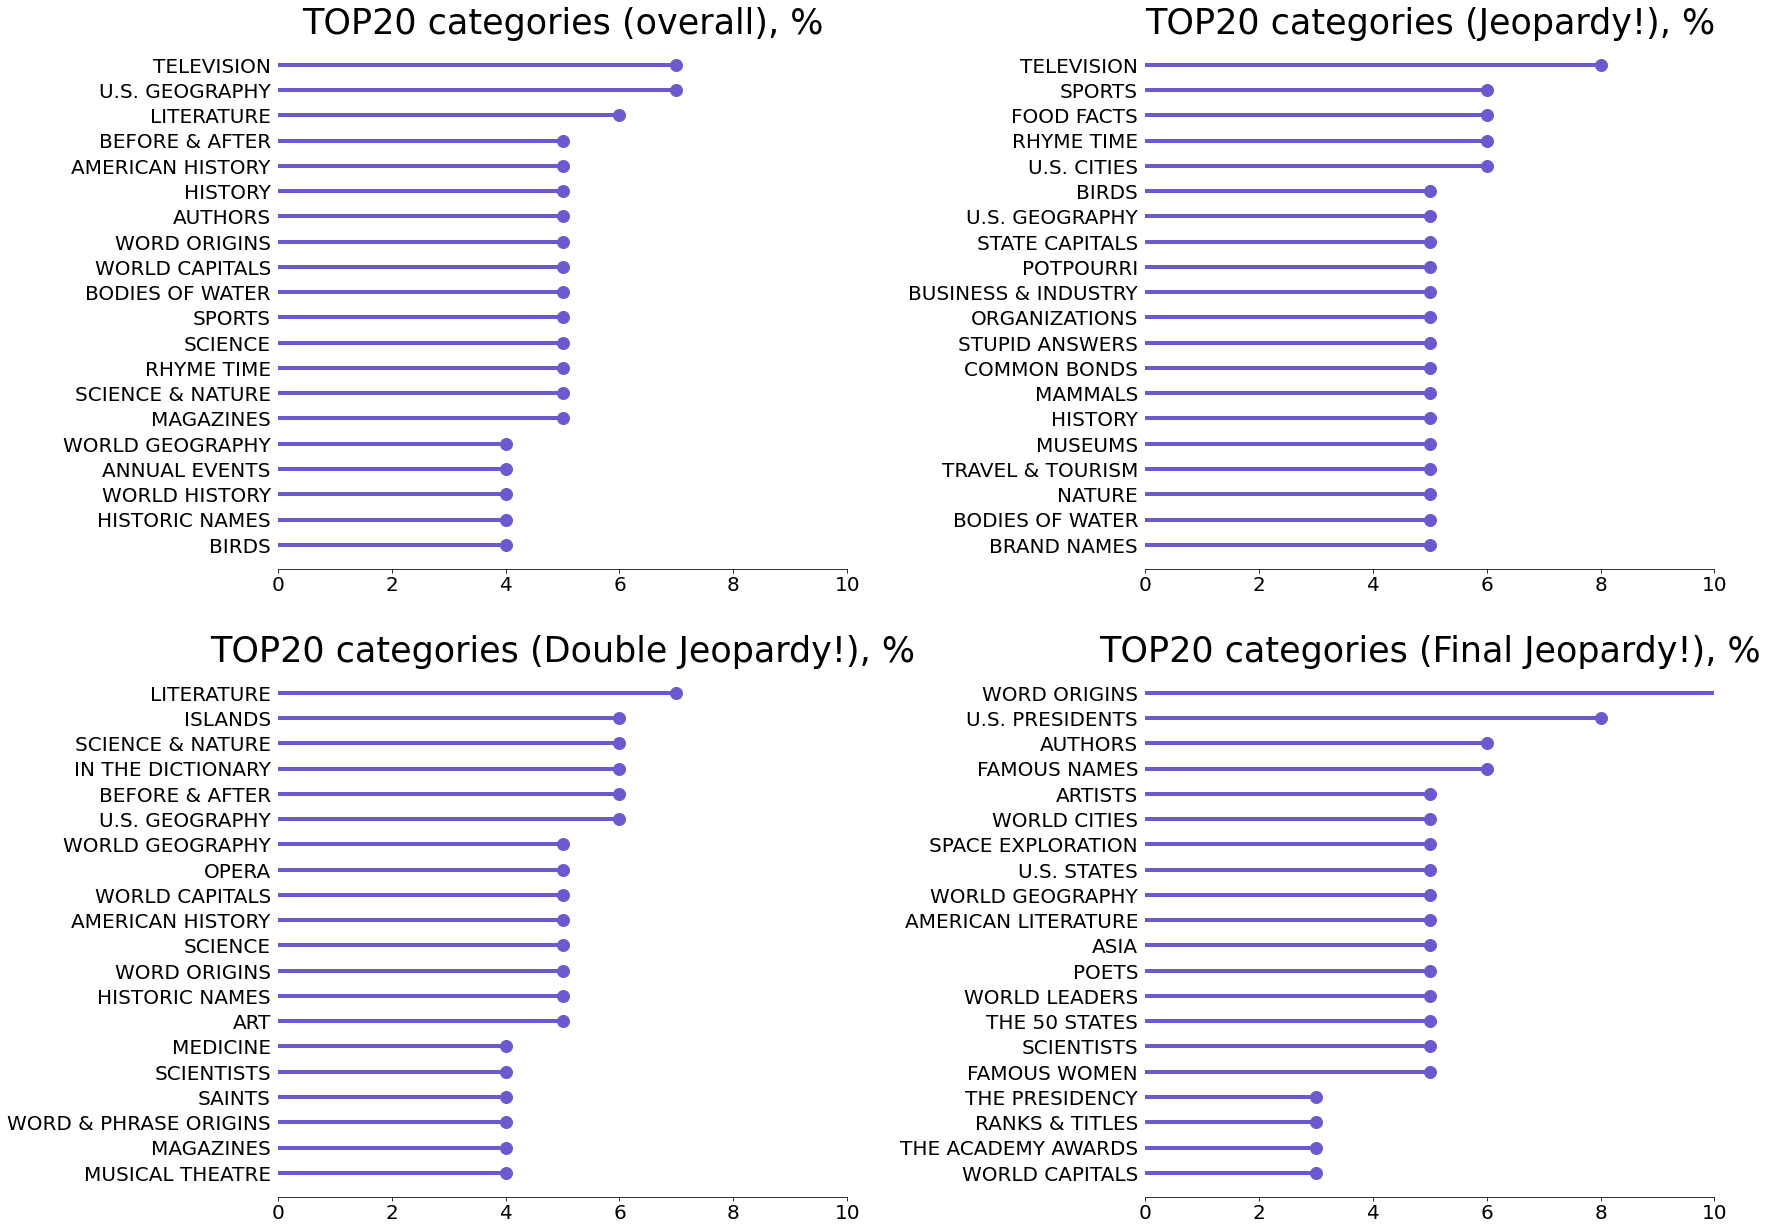

In [18]:
def find_top_20_cat(df):
    '''Takes in a dataframe and returns the TOP20 categories by frequency,
    both in % and in absolute values.
    '''
    top_20_cat_abs = df['Category'].value_counts()[:20].sort_values()
    top_20_cat_pct = round(top_20_cat_abs*100/sum(top_20_cat_abs))
    return top_20_cat_pct, top_20_cat_abs

jeopardy_1 = jeopardy[jeopardy['Round']=='Jeopardy!']
jeopardy_2 = jeopardy[jeopardy['Round']=='Double Jeopardy!']
jeopardy_3 = jeopardy[jeopardy['Round']=='Final Jeopardy!']

# Extracting the TOP20 categories by frequency in %
top_20_cat_pct = find_top_20_cat(jeopardy)[0]
top_20_cat_pct_1 = find_top_20_cat(jeopardy_1)[0]
top_20_cat_pct_2 = find_top_20_cat(jeopardy_2)[0]
top_20_cat_pct_3 = find_top_20_cat(jeopardy_3)[0]

dfs = [top_20_cat_pct, top_20_cat_pct_1, top_20_cat_pct_2, top_20_cat_pct_3]
titles = ['TOP20 categories (overall), %',
          'TOP20 categories (Jeopardy!), %',
          'TOP20 categories (Double Jeopardy!), %',
          'TOP20 categories (Final Jeopardy!), %']

fig = plt.figure(figsize=(25, 18))
for i in range(0,4):
    ax=fig.add_subplot(2,2,i+1) 
    
    # Creating stem plots
    plt.hlines(y=dfs[i].index, 
               xmin=0, xmax=dfs[i], 
               linewidth=4,
               color='slateblue')
    plt.plot(dfs[i], dfs[i].index, 
             'o', ms=12, color='slateblue')
    ax.set_title(titles[i], fontsize=35)
    ax.set_xlim(0,10)
    ax.tick_params(axis='both', labelsize=20, left = False)
    sns.despine(left=True)
    plt.tight_layout(pad=4) 
plt.show()

We can make the following observations from these graphs:
- *Television*, *U.S, Geography*, and *Literature* are the most frequent categories overall, with *Television* especially popular on the first round (*Jeopardy!*), *Literature* – on the second one (*Doubly Jeopardy!*), and *U.S, Geography* rather popular on both.
- As for the 3rd round (*Final Jeopardy!*), represented, as we saw earlier, by only 2% of all the questions, the leaders here are different: *Word Origins* and *U.S. Presidents*. Since we're planning to win also this final round (😉), and since the gap with the rest of the categories of this round seems quite visible, let's add these two categories to our list. Hence, our ultimate list of knowledge spheres to refresh includes **Television**, **U.S, Geography**, **Literature**, **Word Origins**, and **U.S. Presidents**.

However, before rushing to read all these materials in advance, let's check one more thing: the probability to actually have a question from each of these categories. We're going to calculate these probabilities for the following combinations of rounds and categories:
- All rounds – *Television*, *U.S, Geography*, *Literature*,
- 1st round – *Television*,
- 2nd round – *Literature*,
- 3rd round – *Word Origins* and *U.S. Presidents*.

In [19]:
# Extracting the TOP20 categories by frequency in absolute values
top_20_cat_abs = find_top_20_cat(jeopardy)[1]
top_20_cat_abs_1 = find_top_20_cat(jeopardy_1)[1]
top_20_cat_abs_2 = find_top_20_cat(jeopardy_2)[1]
top_20_cat_abs_3 = find_top_20_cat(jeopardy_3)[1]

jeopardy_sets = [jeopardy, jeopardy, jeopardy,
                 jeopardy_1, 
                 jeopardy_2, 
                 jeopardy_3, jeopardy_3]
dfs_new = [top_20_cat_abs, top_20_cat_abs, top_20_cat_abs, 
           top_20_cat_abs_1,
           top_20_cat_abs_2,
           top_20_cat_abs_3, top_20_cat_abs_3]
rounds = ['all rounds', 'all rounds', 'all rounds', 
          '1st round', 
          '2nd round', 
          '3rd round', '3rd round']
cats = ['TELEVISION', 'U.S. GEOGRAPHY', 'LITERATURE',
        'TELEVISION',
        'LITERATURE',
        'WORD ORIGINS', 'U.S. PRESIDENTS']

print('PROBABILITY OF HAVING A QUESTION:')
for i in range(len(dfs_new)):
    p=round(dfs_new[i][cats[i]]/len(jeopardy_sets[i])*100,1)
    print(f'on {rounds[i]} from {cats[i]} category:  \t{p}%')

PROBABILITY OF HAVING A QUESTION:
on all rounds from TELEVISION category:  	0.3%
on all rounds from U.S. GEOGRAPHY category:  	0.3%
on all rounds from LITERATURE category:  	0.2%
on 1st round from TELEVISION category:  	0.4%
on 2nd round from LITERATURE category:  	0.4%
on 3rd round from WORD ORIGINS category:  	2.4%
on 3rd round from U.S. PRESIDENTS category:  	1.5%


In all the cases, the probability to have a question from a certain category at a certain round is extremely low, and we should keep in mind that these categories are even the most frequent ones. The highest (but still very low) probabilities are related to the 3rd round. However, the probability to arrive at the 3rd round itself must be very low. We can assume that considering the most popular categories of questions and studying corresponding materials in advance is also a rather unreliable strategy to increase our chances to win Jeopardy. 

One of the possible ways forward here could be trying to combine adjacent categories in one. For example, 
- *U.S. Geography*, *U.S. States*, *U.S. Cities*, *The 50 States*, *State Capitals*,
- *History*, *World History*, *Historic Names*, *Historic Women*, *People in History*, *Historic Nicknames*,
- *World Geography*, *World Capitals*, *World Cities*, *5-Letter Capitals*.

Such an approach, though, would require a lot of manual work, given that there are 3,581 unique categories and anyway would result in slightly higher but still very low probability values (indeed, we don't expect to find too many adjacent categories). Hence, the approach of defining the most popular categories doesn't work in our case as well.
## Conclusion
In this project, we tried to figure out some successful question-based strategies to win Jeopardy. We used 10% of all the questions from a full Jeopardy dataset. Below are the approaches applied and the results obtained:
- Checking if the answer tends to be hinted at in a question.
    - It happened only in 6% of cases.
- Investigating the possibility of question recycling, whether to study past questions or not.
    - A significant overlap (78%) between meaningful words of all the questions suggests that this is a perspective direction to investigate further.
- Searching for the words mostly related to high value questions rather than low value ones.
    - All of the 50 most frequent words tend to occur mostly in low level questions that are not our target. Digging deeper would be time-consuming and low productive.
- Exploring the most frequent categories overall and by round, to have a list of topics to prepare in advance.
    - The identified categories (*Television*, *U.S. Geography*, *Literature*, *Word Origins*, and *U.S. Presidents*) demonstrate extremely low probability  (maximum 2.4%) to have a question from each of them. Trying to combine adjacent categories in one wouldn’t improve the situation.


Our final conclusion is that **the only realistic and potentially prospective way forward can be investigating question recycling in more detail**.